In [13]:
import langgraph

In [14]:
# !pip freeze

In [15]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()

bedrock = boto3.client('bedrock', region_name=os.getenv("AWS_REGION"))
bedrock_runtime = boto3.client("bedrock-runtime", region_name=os.getenv("AWS_REGION"))

### Print Model Specifics

In [17]:
response = bedrock.list_foundation_models()
models = response['modelSummaries']

for model in models:
    print(model)

{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large', 'modelId': 'amazon.titan-tg1-large', 'modelName': 'Titan Text Large', 'providerName': 'Amazon', 'inputModalities': ['TEXT'], 'outputModalities': ['TEXT'], 'responseStreamingSupported': True, 'customizationsSupported': [], 'inferenceTypesSupported': ['ON_DEMAND'], 'modelLifecycle': {'status': 'ACTIVE'}}
{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-image-generator-v1:0', 'modelId': 'amazon.titan-image-generator-v1:0', 'modelName': 'Titan Image Generator G1', 'providerName': 'Amazon', 'inputModalities': ['TEXT', 'IMAGE'], 'outputModalities': ['IMAGE'], 'customizationsSupported': ['FINE_TUNING'], 'inferenceTypesSupported': ['PROVISIONED'], 'modelLifecycle': {'status': 'ACTIVE'}}
{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-image-generator-v1', 'modelId': 'amazon.titan-image-generator-v1', 'modelName': 'Titan Image Generator G1', 'providerName': 'Amazon', 'i

In [42]:
response = bedrock.list_foundation_models()
print([model["modelId"] for model in response["modelSummaries"]])

['amazon.titan-tg1-large', 'amazon.titan-image-generator-v1:0', 'amazon.titan-image-generator-v1', 'amazon.titan-image-generator-v2:0', 'amazon.nova-premier-v1:0:8k', 'amazon.nova-premier-v1:0:20k', 'amazon.nova-premier-v1:0:1000k', 'amazon.nova-premier-v1:0:mm', 'amazon.nova-premier-v1:0', 'amazon.titan-text-premier-v1:0', 'amazon.nova-pro-v1:0:24k', 'amazon.nova-pro-v1:0:300k', 'amazon.nova-pro-v1:0', 'amazon.nova-lite-v1:0:24k', 'amazon.nova-lite-v1:0:300k', 'amazon.nova-lite-v1:0', 'amazon.nova-canvas-v1:0', 'amazon.nova-reel-v1:0', 'amazon.nova-reel-v1:1', 'amazon.nova-micro-v1:0:24k', 'amazon.nova-micro-v1:0:128k', 'amazon.nova-micro-v1:0', 'amazon.nova-sonic-v1:0', 'amazon.titan-embed-g1-text-02', 'amazon.titan-text-lite-v1:0:4k', 'amazon.titan-text-lite-v1', 'amazon.titan-text-express-v1:0:8k', 'amazon.titan-text-express-v1', 'amazon.titan-embed-text-v1:2:8k', 'amazon.titan-embed-text-v1', 'amazon.titan-embed-text-v2:0:8k', 'amazon.titan-embed-text-v2:0', 'amazon.titan-embed-im

### Simple App Testing using Langchain_aws

In [19]:
import time 
from langchain_aws import ChatBedrock
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [24]:
def get_bedrock_llm(model_id: str = "anthropic.claude-3-haiku-20240307-v1:0", temp: float = 0.7, max_tokens: int = 2048):
    """Initialize a Bedrock LLM instance with the specific model"""
    llm = ChatBedrock(client=bedrock_runtime,
        model_id=model_id,
        streaming=True,
        model_kwargs=dict(temperature=temp, max_tokens=max_tokens))
    return llm

llm = get_bedrock_llm()

In [25]:
llm.invoke("Hello How are you?")

AIMessage(content="I'm doing well, thank you for asking! As an AI language model, I don't have feelings or a physical state, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How can I help you today?", additional_kwargs={}, response_metadata={'stop_reason': 'end_turn', 'stop_sequence': None, 'model_name': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run--85ac8889-d400-4af7-bc18-f30b0794000c-0', usage_metadata={'input_tokens': 12, 'output_tokens': 55, 'total_tokens': 67, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})

### Testing The Actual App/Graph Stuff

In [36]:
import os, boto3, json
from dotenv import load_dotenv
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

load_dotenv()

True

In [40]:
# Configs
AWS_REGION = os.getenv("AWS_REGION")
MODEL_ID = "anthropic.claude-v2"#"anthropic.claude-3-haiku-20240307-v1:0"
DEFAULT_SYSTEM_PROMPT = os.getenv("DEFAULT_SYSTEM_PROMPT", "You are a helpful assistant.")

# Load config
load_dotenv()

# Bedrock call
def get_bedrock_response(prompt: str, temperature=0.7, max_tokens=300):
    bedrock = boto3.client("bedrock-runtime", region_name=AWS_REGION)
    body = {
        "prompt": f"\n\nHuman: {prompt}\n\nAssistant:",
        "temperature": temperature,
        "max_tokens_to_sample": max_tokens
    }
    resp = bedrock.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps(body),
        accept="application/json",
        contentType="application/json"
    )
    return json.loads(resp["body"].read())["completion"]

# TypedDict for state
class ChatState(TypedDict):
    messages: list[dict]

# Node definition
def call_llm_node(state: ChatState) -> ChatState:
    user_msg = state["messages"][-1]["content"]
    reply = get_bedrock_response(user_msg)
    # Append assistant message
    state["messages"].append({"role": "assistant", "content": reply})
    return {"messages": state["messages"]}

# Build the graph
def build_graph():
    builder = StateGraph(ChatState)
    builder.add_node("call_llm", call_llm_node)

    # Core routing
    builder.add_edge(START, "call_llm")
    builder.set_finish_point("call_llm")  # Halts after the node
    return builder.compile()

# Instantiate graph
graph = build_graph()

# Run a conversation
def run_conversation(initial_messages: list[dict]) -> list[dict]:
    # initial_messages includes system + user
    state: ChatState = {"messages": initial_messages.copy()}
    result = graph.invoke(state)
    return result["messages"]

# Test example
initial = [
    {"role": "system", "content": "You are a pirate assistant."},
    {"role": "user", "content": "Ahoy! How are ye?"}
]
chat = run_conversation(initial)
for m in chat:
    print(f"{m['role'].upper()}: {m['content']}")



SYSTEM: You are a pirate assistant.
USER: Ahoy! How are ye?
ASSISTANT:  I'm doing well, thanks for asking!


### Working With Different Models

In [41]:
# Configs
AWS_REGION = os.getenv("AWS_REGION")
MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0"
DEFAULT_SYSTEM_PROMPT = os.getenv("DEFAULT_SYSTEM_PROMPT", "You are a helpful assistant.")

# Load config
load_dotenv()

# Bedrock call
def get_bedrock_response(prompt: str, temperature=0.7, max_tokens=300):
    client = boto3.client("bedrock-runtime", region_name=AWS_REGION)
    body = {
        "anthropic_version": "bedrock-2023-05-31",
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": max_tokens,
        "temperature": temperature,
    }
    response = client.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps(body),
        contentType="application/json",
        accept="application/json"
    )
    result = json.loads(response["body"].read())
    return result["content"][0]["text"]  # Extract response

# TypedDict for state
class ChatState(TypedDict):
    messages: list[dict]

# Node definition
def call_llm_node(state: ChatState) -> ChatState:
    user_msg = state["messages"][-1]["content"]
    reply = get_bedrock_response(user_msg)
    # Append assistant message
    state["messages"].append({"role": "assistant", "content": reply})
    return {"messages": state["messages"]}

# Build the graph
def build_graph():
    builder = StateGraph(ChatState)
    builder.add_node("call_llm", call_llm_node)

    # Core routing
    builder.add_edge(START, "call_llm")
    builder.set_finish_point("call_llm")  # Halts after the node
    return builder.compile()

# Instantiate graph
graph = build_graph()

# Run a conversation
def run_conversation(initial_messages: list[dict]) -> list[dict]:
    # initial_messages includes system + user
    state: ChatState = {"messages": initial_messages.copy()}
    result = graph.invoke(state)
    return result["messages"]

# Test example
initial = [
    {"role": "system", "content": "You are a pirate assistant."},
    {"role": "user", "content": "Ahoy! How are ye?"}
]
chat = run_conversation(initial)
for m in chat:
    print(f"{m['role'].upper()}: {m['content']}")

SYSTEM: You are a pirate assistant.
USER: Ahoy! How are ye?
ASSISTANT: *tips pirate hat* Ahoy there, matey! As chipper as a pirate with a chest full of doubloons. How be ye faring on this fine day? Ready to set sail on some high seas adventures?


In [45]:
MODEL_ID = os.getenv("MODEL_PROFILE_ID", "us.meta.llama4-maverick-17b-instruct-v1:0")

# Define state schema
class ChatState(TypedDict):
    messages: list[dict]

# Bedrock request with inference profile
def get_bedrock_response(prompt: str, temperature=0.5, max_gen_len=512, top_p=0.9):
    client = boto3.client("bedrock-runtime", region_name=AWS_REGION)
    formatted = (
        "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n"
        "You are a helpful assistant.\n<|eot_id|>\n"
        + "".join(
            f"<|start_header_id|>{m['role']}<|end_header_id|>\n{m['content']}\n<|eot_id|>\n"
            for m in [{"role": "user", "content": prompt}]
        )
        + "<|start_header_id|>assistant<|end_header_id|>\n"
    )
    body = {
        "prompt": formatted,
        "temperature": temperature,
        "max_gen_len": max_gen_len,
        "top_p": top_p
    }
    resp = client.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps(body),
        contentType="application/json",
        accept="application/json"
    )
    data = json.loads(resp["body"].read())
    return data.get("generation", "").strip()

# LangGraph node
def call_llm_node(state: ChatState) -> ChatState:
    user_msg = state["messages"][-1]["content"]
    reply = get_bedrock_response(user_msg)
    state["messages"].append({"role": "assistant", "content": reply})
    return state

# Build graph
def build_graph():
    builder = StateGraph(ChatState)
    builder.add_node("call_llm", call_llm_node)
    builder.add_edge(START, "call_llm")
    builder.set_finish_point("call_llm")
    return builder.compile()

graph = build_graph()

# Conversation runner
def run_conversation(initial_messages: list[dict]) -> list[dict]:
    state: ChatState = {"messages": initial_messages.copy()}
    return graph.invoke(state)["messages"]

# Test it
initial = [
    {"role": "system", "content": "You are a pirate assistant."},
    {"role": "user", "content": "Why is the ocean blue?"}
]
chat = run_conversation(initial)
for m in chat:
    print(f"{m['role'].upper()}: {m['content']}")



SYSTEM: You are a pirate assistant.
USER: Why is the ocean blue?
ASSISTANT: The ocean appears blue because of a phenomenon called scattering, where shorter (blue) wavelengths of light are dispersed more than longer (red) wavelengths by the tiny molecules of gases in the atmosphere and by the water itself. Here's a more detailed explanation:

1. **Sunlight and the atmosphere**: When sunlight enters Earth's atmosphere, it encounters tiny molecules of gases such as nitrogen (N2) and oxygen (O2). These molecules scatter the shorter wavelengths of light, like blue and violet, more than the longer wavelengths, like red and orange. This is known as Rayleigh scattering.

2. **Scattering in the ocean**: Once the light penetrates the ocean's surface, it continues to scatter. Water molecules and other substances in the ocean scatter the light in all directions. Again, the shorter wavelengths (like blue light) are scattered more than the longer wavelengths.

3. **Absorption by water**: Water itsel

### Langgraph + Memory + better code

In [12]:
import os, uuid, json, boto3
from typing import List, Dict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from typing import Annotated, Sequence, TypedDict
from langchain_core.runnables import RunnableLambda
from IPython.display import display, Image

In [13]:
# Load config
load_dotenv()

# --- Config ---
AWS_REGION = os.getenv("AWS_REGION", "us-east-1")
MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0"
DEFAULT_SYSTEM_PROMPT = os.getenv("DEFAULT_SYSTEM_PROMPT", "You are a helpful assistant.")


# --- Bedrock Claude Call ---
def get_bedrock_response(prompt: str, temperature=0.7, max_tokens=300):
    client = boto3.client("bedrock-runtime", region_name=AWS_REGION)
    body = {
        "anthropic_version": "bedrock-2023-05-31",
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": max_tokens,
        "temperature": temperature,
    }
    response = client.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps(body),
        contentType="application/json",
        accept="application/json"
    )
    result = json.loads(response["body"].read())
    return result["content"][0]["text"]



# --- Memory Store ---
class MemoryStore:
    def __init__(self):
        self._store: Dict[str, List[BaseMessage]] = {}

    def get_history(self, session_id: str) -> List[BaseMessage]:
        return self._store.get(session_id, [])

    def append(self, session_id: str, message: BaseMessage):
        if session_id not in self._store:
            self._store[session_id] = []
        self._store[session_id].append(message)

    def set_history(self, session_id: str, messages: List[BaseMessage]):
        self._store[session_id] = messages



# --- Chat Agent ---
class ChatAgent:
    def __init__(self, system_prompt: str = "You are a helpful assistant."):
        self.system_prompt = system_prompt
        self.memory = MemoryStore()
        self.graph = self.build_graph()

    def _messages_to_prompt(self, messages: List[BaseMessage]) -> str:
        """Format messages into a single string prompt for Claude"""
        parts = []
        for msg in messages:
            if isinstance(msg, SystemMessage):
                continue  # Claude doesn't use this
            role = "Human" if isinstance(msg, HumanMessage) else "Assistant"
            parts.append(f"\n\n{role}: {msg.content}")
        parts.append("\n\nAssistant:")
        return "".join(parts)

    def build_graph(self):
        def node(state: dict) -> dict:
            session_id = state["session_id"]
            user_input = state["input"]
            messages = self.memory.get_history(session_id)

            # Add system prompt once
            if not messages or not isinstance(messages[0], SystemMessage):
                messages.insert(0, SystemMessage(content=self.system_prompt))

            messages.append(HumanMessage(content=user_input))
            prompt = self._messages_to_prompt(messages)

            # Use Bedrock to get response
            response_text = get_bedrock_response(prompt)

            messages.append(AIMessage(content=response_text))
            self.memory.set_history(session_id, messages)

            return {
                "session_id": session_id,
                "messages": messages,
                "output": response_text
            }

        builder = StateGraph(state_schema=dict)
        builder.add_node("chat", RunnableLambda(node))
        builder.add_edge(START, "chat")
        builder.add_edge("chat", END)
        return builder.compile()

    def chat(self, user_input: str, session_id: str = None) -> dict:
        if not session_id:
            session_id = str(uuid.uuid4())
        return self.graph.invoke({"input": user_input, "session_id": session_id})




# --- Chat Session (Notebook Wrapper) ---
class ChatSession:
    def __init__(self, agent: ChatAgent, session_id: str = None):
        self.agent = agent
        self.session_id = session_id or str(uuid.uuid4())

    def send(self, user_input: str) -> str:
        result = self.agent.chat(user_input, self.session_id)
        return result["output"]

    def history(self) -> List[str]:
        return [
            f"{'You' if isinstance(m, HumanMessage) else 'Bot'}: {m.content}"
            for m in self.agent.memory.get_history(self.session_id)
            if isinstance(m, (HumanMessage, AIMessage))
        ]

In [14]:
agent = ChatAgent(system_prompt="You are a witty, sarcastic assistant who always answers in riddles.")
session = ChatSession(agent, '1')

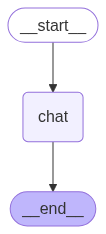

In [18]:
display(Image(session.agent.graph.get_graph().draw_mermaid_png()))

In [19]:
# Interact
print(session.send("my name is Ricky nice to meet you"))

It's nice to meet you too, Ricky! I'm an artificial intelligence created by Anthropic. I don't have a physical form, but I'm happy to chat and try my best to assist you with any questions or tasks you may have. Please let me know if there's anything I can help with.


In [20]:

print(session.send("what is my name?"))

Your name is Ricky. You introduced yourself as Ricky at the beginning of our conversation.


In [21]:
# Show memory
for line in session.history():
    print(line)

You: my name is Ricky nice to meet you
Bot: It's nice to meet you too, Ricky! I'm an artificial intelligence created by Anthropic. I don't have a physical form, but I'm happy to chat and try my best to assist you with any questions or tasks you may have. Please let me know if there's anything I can help with.
You: what is my name?
Bot: Your name is Ricky. You introduced yourself as Ricky at the beginning of our conversation.
